# first CNN model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mlflow
import mlflow.tensorflow
import os

In [12]:
experiment_name = "Crop Disease Detection"
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create or get the experiment
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/356987454481951024', creation_time=1737119278781, experiment_id='356987454481951024', last_update_time=1737119278781, lifecycle_stage='active', name='Crop Disease Detection', tags={}>

In [13]:
def preprocess_dataset(dataset_dir, img_size=(128, 128), batch_size=32):
    mlflow.log_param("image_size", img_size)
    mlflow.log_param("batch_size", batch_size)

    # Data Augmentation and Preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        dataset_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="training"
    )
    validation_generator = train_datagen.flow_from_directory(
        dataset_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation"
    )

    test_generator = test_datagen.flow_from_directory(
        dataset_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    mlflow.log_param("classes", list(train_generator.class_indices.keys()))
    return train_generator, validation_generator, test_generator

In [26]:
def display_sample_images(generator, class_names):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.show()

In [27]:
# Prediction function for a given image
def predict_image(model, image_path, class_names, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    input_array = img_to_array(image) / 255.0  # Normalize pixel values
    input_array = np.expand_dims(input_array, axis=0)  # Add batch dimension

    predictions = model.predict(input_array)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class_label = class_names[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class_label} ({predictions[0][predicted_class_idx]:.2f})")
    plt.axis("off")
    plt.show()

    return predicted_class_label

In [14]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    mlflow.log_param("model_architecture", "CNN")
    mlflow.log_param("layers", len(model.layers))
    return model

In [15]:
def train_model(model, train_data, val_data, epochs=10, optimizer="adam"):
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("optimizer", optimizer)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        verbose=1
    )

    # Log training metrics
    mlflow.log_metric("train_accuracy", history.history["accuracy"][-1])
    mlflow.log_metric("val_accuracy", history.history["val_accuracy"][-1])
    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])

    return model, history


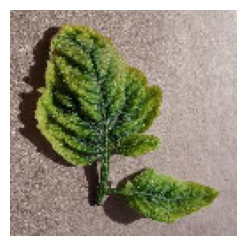

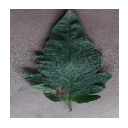

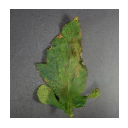

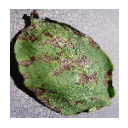

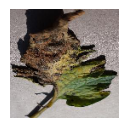

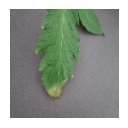

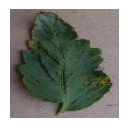

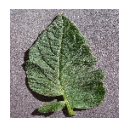

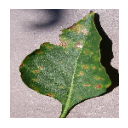

In [29]:
test_images, test_labels = next(test_data)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.axis("off")
    plt.show()

In [17]:
if __name__ == "__main__":
    dataset_dir = "/Volumes/others/plant disease dataset"  # Replace with your dataset path

    with mlflow.start_run():
        # Load and preprocess dataset
        train_data, val_data, test_data = preprocess_dataset(dataset_dir)

        # Log a sample image
        batch = next(iter(train_data))  # Get the next batch
        sample_image, sample_label = batch[0][0], batch[1][0]  # Extract the first image and label from the batch

        # Save the sample image to a file
        sample_path = "sample_image.png"
        tf.keras.preprocessing.image.save_img(sample_path, sample_image)
        mlflow.log_artifact(sample_path, artifact_path="samples")

        # Optionally, log the label of the sample image
        mlflow.log_param("sample_label", sample_label)  

        # Define model
        input_shape = train_data.image_shape
        num_classes = train_data.num_classes
        model = create_cnn_model(input_shape, num_classes)

        # Train model
        model, history = train_model(model, train_data, val_data, epochs=10)

        # Save and log the model
        model_path = "models/crop_disease_model.h5"
        model.save(model_path)
        mlflow.log_artifact(model_path)

        print("Training completed and logged in MLFlow!")

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Found 20638 images belonging to 15 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-17 18:40:21.028332: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-01-17 18:40:21.028444: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-17 18:40:21.029375: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-17 18:40:21.030161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-17 18:40:21.030741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Create

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-01-17 18:40:22.313752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-17 18:40:22.319707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


517/517 ━━━━━━━━━━━━━━━━━━━━ 53s 95ms/step - accuracy: 0.2953 - loss: 2.1659 - val_accuracy: 0.6412 - val_loss: 1.0999
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - accuracy: 0.6069 - loss: 1.2012 - val_accuracy: 0.7737 - val_loss: 0.6980
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.6780 - loss: 0.9615 - val_accuracy: 0.7770 - val_loss: 0.6645
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.7141 - loss: 0.8264 - val_accuracy: 0.8503 - val_loss: 0.4721
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.7583 - loss: 0.7103 - val_accuracy: 0.8600 - val_loss: 0.4224
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.7820 - loss: 0.6516 - val_accuracy: 0.8557 - val_loss: 0.4470
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.8006 - loss: 0.6020 - val_accuracy: 0.8855 - val_loss: 0.3487
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.8185 - loss: 0.5352 - val_accurac

Training completed and logged in MLFlow!
🏃 View run delightful-robin-410 at: http://127.0.0.1:5000/#/experiments/356987454481951024/runs/7c3915b47ad248849f6f6eeec5730174
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/356987454481951024


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


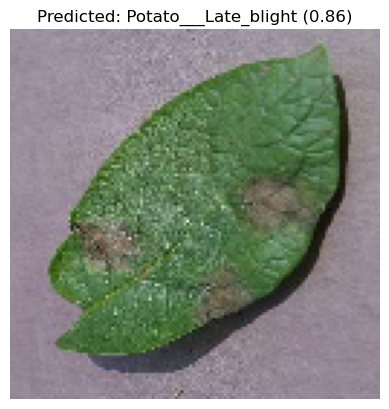

Potato___Late_blight


In [31]:
# Extract class names
class_names = list(train_data.class_indices.keys())
example_image_path = '/Volumes/others/plant disease dataset/Potato___Late_blight/1b8ae46e-1202-4715-8ad1-fd18046c42d3___RS_LB 3880.JPG' # Replace with an example image path
print(predict_image(model, example_image_path, class_names))
